an example:

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

##### DATA #####
curve_length = 100
num_parameters = 3

num_samples = 2000

X = torch.randn(num_samples, curve_length)

A = torch.randn(num_samples, num_parameters)

X_train, X_val = X[:1500], X[1500:]
A_train, A_val = A[:1500], A[1500:]

##### Model with dropout? #####

class CurveRegressor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        return self.net(x)
    
model = CurveRegressor(curve_length, num_parameters)

##### Training - Setup #####

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

##### Training - Loop #####

for epoch in range(20):
    model.train()
    optimizer.zero_grad()

    preds = model(X_train)
    loss = criterion(preds, A_train)

    loss.backward()
    optimizer.step()

    # validation loss
    with torch.no_grad():
        model.eval()
        val_loss = criterion(model(X_val), A_val)

    print(f"Epoch {epoch:02d} | train loss: {loss.item():.4f} | val loss: {val_loss.item():.4f}")

##### inference with uncertainty #####

# random new curve
x_new = torch.randn(1, curve_length)

num_samples_mc = 50
preds = []

model.train()

with torch.no_grad():
    for _ in range(num_samples_mc):
        preds.append(model(x_new))

preds = torch.stack(preds) # shape [num_samples_mc, 1, num_parameters]

mean_prediction = preds.mean(dim = 0)
std_prediction = preds.std(dim = 0)

print("\nMean prediction:\n", mean_prediction)
print("\nStd dev (uncertainty):\n", std_prediction)

Epoch 00 | train loss: 1.0410 | val loss: 0.9719
Epoch 01 | train loss: 1.0303 | val loss: 0.9715
Epoch 02 | train loss: 1.0164 | val loss: 0.9680
Epoch 03 | train loss: 1.0041 | val loss: 0.9675
Epoch 04 | train loss: 0.9927 | val loss: 0.9698
Epoch 05 | train loss: 0.9859 | val loss: 0.9723
Epoch 06 | train loss: 0.9703 | val loss: 0.9744
Epoch 07 | train loss: 0.9612 | val loss: 0.9764
Epoch 08 | train loss: 0.9466 | val loss: 0.9791
Epoch 09 | train loss: 0.9371 | val loss: 0.9823
Epoch 10 | train loss: 0.9272 | val loss: 0.9861
Epoch 11 | train loss: 0.9141 | val loss: 0.9907
Epoch 12 | train loss: 0.9015 | val loss: 0.9969
Epoch 13 | train loss: 0.8881 | val loss: 1.0047
Epoch 14 | train loss: 0.8777 | val loss: 1.0128
Epoch 15 | train loss: 0.8656 | val loss: 1.0200
Epoch 16 | train loss: 0.8500 | val loss: 1.0269
Epoch 17 | train loss: 0.8401 | val loss: 1.0343
Epoch 18 | train loss: 0.8253 | val loss: 1.0417
Epoch 19 | train loss: 0.8127 | val loss: 1.0487

Mean prediction:
 t

okay, lets do the real thing now

# notes:
something something things are more stable with normalisation? idk how to scale and unscale everything :(

maybe abstractify reading in data cube (possible) - this is already done lmao, its effectively a path + one liner
and spectrum to fit (less possible as the spectra have no standardised way of being saved - but could make e.g. a JWST method, a HST method, etc... but maybe later lmao) 

In [1]:
%matplotlib widget

K2-18


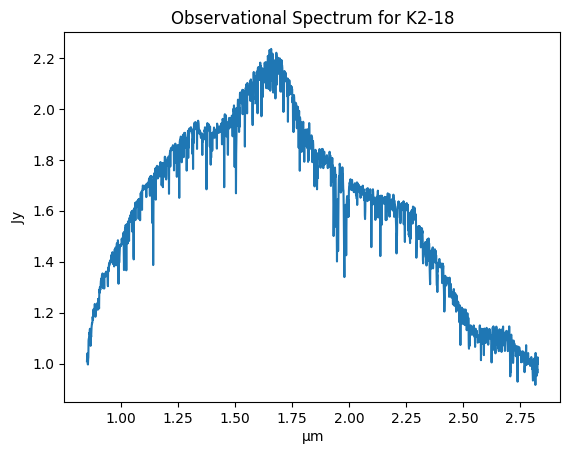

appending values from data cube to y_curves, params lists: 100%|██████████| 2106/2106 [00:49<00:00, 42.80it/s]


In [29]:
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
from itertools import product
from tqdm import tqdm
from astropy.visualization import quantity_support
quantity_support() # required for numpy to not get annoyed when doing e.g. np.stack()

from spots_and_faculae_model.readers import read_JWST_fits
from spots_and_faculae_model.spectrum import spectrum
from spots_and_faculae_model.spectrum_grid import spectrum_grid

"""
one difference between this and main.ipynb is that here the spectra are processed by appending rows into the matrix A, whereas in main.ipynb spectra are appended as _columns_ into the matrix A
"""

# read in spectrum to fit
external_spectrum_path = Path("../../assets/MAST_2025-10-26T08_10_09.071Z/MAST_2025-10-26T08_10_09.071Z/JWST/jw02722003001_04101_00001-seg001_nis_x1dints.fits")
script_dir = os.getcwd()
wavelength_grid_absolute_path = (script_dir / external_spectrum_path).resolve()
spectrum_to_decompose : spectrum = read_JWST_fits(wavelength_grid_absolute_path, name = "K2-18")
print(spectrum_to_decompose.Name)
mask = np.isfinite(spectrum_to_decompose.Fluxes) # mask that removes np.inf values from spectra - this could be observational spectra dependent; so we have to apply this to the data cube after creating the data cube, not before
spectrum_to_decompose = spectrum_to_decompose[mask]
spectrum_to_decompose.normalise_Janskys()

spectrum_to_decompose.plot()

# read in spectral cube
spectral_grid_relative_path = Path("../../assets/spectral_grid.hdf5")
spectral_grid_absolute_path = (script_dir / spectral_grid_relative_path).resolve()
spec_grid : spectrum_grid = spectrum_grid.from_hdf5_file(absolute_hdf5_path=spectral_grid_absolute_path)
# print(spec_grid.Table)

# read in spectrum to decompose - use it to determine the following 
spectrum_num_points = len(spectrum_to_decompose)

# read in data cube - use it to determine the following
number_parameters : int = 3 # T_eff, FeH, log_g
number_phoenix_spectra : int = len(spec_grid.T_effs) * len(spec_grid.FeHs) * len(spec_grid.log_gs) # number of spectra we'll use for train/val

# so each ROW in X,A is 1 graph
# and the columns of X are just the graph values (ys)
# and the columns of X are the different parameters )

# effectively we're doing the same thing as in main.ipynb, but without the horrendous bodge for working out what the weights are
# here, we're being systematic about the weights and their meaning by appending them all to a matrix (# of PHOENIX spectra rows x 3 columns) beforehand
y_curves = []
params = []
for T_eff, FeH, log_g in tqdm(product(spec_grid.T_effs, spec_grid.FeHs, spec_grid.log_gs), total=len(spec_grid.T_effs) * len(spec_grid.FeHs) * len(spec_grid.log_gs), desc="appending values from data cube to y_curves, params lists"):
    y_curves.append(spec_grid.process_single_spectral_component(T_eff=T_eff, FeH=FeH, log_g=log_g, mask=mask, spectrum_to_decompose=spectrum_to_decompose))
    # numpy requires that all columns (in the A matrix) have the same astropy unit (I think?) so we're gonna have to abandon our lovely astropy units here :(
    # Note: T_eff is the only quantity; the others are just numbers
    params.append([T_eff.value, FeH, log_g])

In [127]:
# X = np.stack([y_curves for spectrum in data_cube(1...number_phoenix_spectra)])
X = np.stack(y_curves)

# A = np.stack([list_of_params_that_describe_curve_1,...,number_parameters])
A = np.stack(params)

from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler()
X_tensor = torch.tensor(X_scaler.fit_transform(X), dtype=torch.float32)

A_scaler = StandardScaler()
A_tensor = torch.tensor(A_scaler.fit_transform(A), dtype=torch.float32)

# X_tensor = torch.tensor(X, dtype=torch.float32)
# A_tensor = torch.tensor(A, dtype=torch.float32)

training_fraction : float = 0.7
validation_fraction : float = 1.0 - training_fraction
# testing?
print(len(y_curves), " ", len(params))

cutoff : int = int(number_phoenix_spectra * training_fraction)

X_train, X_val = X_tensor[:cutoff], X_tensor[cutoff:]
A_train, A_val = A_tensor[:cutoff], A_tensor[cutoff:]

2106   2106


In [128]:
display(X_train)
display(A_train)

tensor([[ 0.0000, -0.1405, -0.1356,  ..., -0.6358, -0.6553, -0.6575],
        [ 0.0000,  0.2644,  0.2530,  ..., -0.5997, -0.6196, -0.6217],
        [ 0.0000,  0.4228,  0.3996,  ..., -0.4398, -0.4595, -0.4616],
        ...,
        [ 0.0000,  0.5736,  0.5872,  ..., -0.2731, -0.2627, -0.2835],
        [ 0.0000,  0.4590,  0.4731,  ..., -0.2341, -0.2267, -0.2406],
        [ 0.0000,  0.3263,  0.3411,  ..., -0.1773, -0.1706, -0.1802]])

tensor([[-1.6384, -1.8332, -1.6036],
        [-1.6384, -1.8332, -1.3363],
        [-1.6384, -1.8332, -1.0690],
        ...,
        [ 0.6746,  0.4313, -1.0690],
        [ 0.6746,  0.4313, -0.8018],
        [ 0.6746,  0.4313, -0.5345]])

In [129]:
class CurveRegressor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            # nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.net(x)

model = CurveRegressor(spectrum_num_points, number_parameters)

In [135]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-4)#, weight_decay=1e-4)

max_epochs : int = 1600
progress_bar = tqdm(range(max_epochs), desc=f"Initialising...")

best_val_loss = np.inf
patience_counter = 0
patience = 10

for epoch in progress_bar:
    model.train()
    optimizer.zero_grad()

    preds = model(X_train)
    loss = criterion(preds, A_train)

    loss.backward()
    optimizer.step()

    # validation loss
    with torch.no_grad():
        model.eval()
        val_loss = criterion(model(X_val), A_val)
    
    progress_bar.set_description(f"Epoch {epoch:02d} | train loss: {loss:.4f} | val loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print("[ML] : early stopping")
        break

Epoch 13 | train loss: 0.0438 | val loss: 0.2527:   1%|          | 13/1600 [00:00<00:21, 75.33it/s]

[ML] : early stopping


In [ ]:

num_samples_mc = 500 # number of Monte Carlo forward passes used for MC-Dropout to estimate uncertainty.
preds = []

model.train()

# scale fluxes by same X_scaler that we used to scale the training data
x_input_scaled = X_scaler.transform(spectrum_to_decompose.Fluxes.reshape(1, -1))
x_tensor = torch.tensor(x_input_scaled, dtype=torch.float32)

# x_tensor = torch.tensor(spectrum_to_decompose.Fluxes, dtype=torch.float32)

with torch.no_grad():
    for _ in range(num_samples_mc):
        preds.append(model(x_tensor))

preds = torch.stack(preds) # shape [num_samples_mc, 1, number_parameters]

mean_prediction = preds.mean(dim = 0)
std_prediction = preds.std(dim = 0)

# print("Mean prediction")
# print(f"T_eff = {mean_prediction[0]}")
# print(f"FeH = {mean_prediction[1]}")
# print(f"log_g = {mean_prediction[2]}")

# print("Std dev (uncertainty)")
# print(f"T_eff = {std_prediction[0]}")
# print(f"FeH = {std_prediction[1]}")
# print(f"log_g = {std_prediction[2]}")

mean_pred_scaled = mean_prediction.detach().numpy()
mean_pred_physical = A_scaler.inverse_transform(mean_pred_scaled.reshape(1, -1))[0]

std_pred_scaled = std_prediction.detach().numpy()
std_pred_physical = std_pred_scaled * A_scaler.scale_

print("Mean prediction")
print(f"T_eff = {mean_pred_physical[0]}")
print(f"FeH = {mean_pred_physical[1]}")
print(f"log_g = {mean_pred_physical[2]}")

print("\n")

print("Std dev (uncertainty)")
print(f"T_eff = {std_pred_physical[0][1]}")
print(f"FeH = {std_pred_physical[0][1]}")
print(f"log_g = {std_pred_physical[0][2]}")

Mean prediction
T_eff = tensor([0.6330, 0.5210, 1.3069])


IndexError: index 1 is out of bounds for dimension 0 with size 1